In [1]:
version = 'v20250521'

import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np

# params
prop = 'slope'
tgt = 'ts_slope'
space = 'normal'

## read in data

In [2]:
covs = pd.read_csv(f'./metric/feature_selected_slope_{version}.txt', header=None)[0].tolist() 
model = joblib.load(f'./model/model_rf.slope_ccc_{version}.joblib')
model.n_jobs = 90

train = pd.read_parquet(f'./material/srs_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)
test = pd.read_parquet(f'./material/srs_test_{version}.pq')
test = test.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)

# train = train.loc[train['soc']<50]
# test = test.loc[test['soc']<50]

## generate prediction and uncertainty

In [3]:
# train the model
from trees_rf import cast_tree_rf, cast_node_rf, pad_leaf_outputs_to_array
import warnings
warnings.filterwarnings("ignore", message="X has feature names, but")
model.fit(train[covs], train[tgt])

# variable importance
importance_df = pd.DataFrame({'feature': covs, 'importance': model.feature_importances_})
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
importance_df.to_csv(f'./metric/feature_importance.{prop}_{version}.csv', index=False)


In [4]:
# generate prediction
y_pred = model.predict(test[covs])
test[f'pred'] = y_pred

# cast the model
ttprint(f'start casting')
model = cast_node_rf(model, train[covs], train[tgt])
ttprint(f'finish casting')

# generate uncertainty
ttprint(f'start predicting')
node_predictions = model.predict(test[covs])
nodes = pad_leaf_outputs_to_array(node_predictions, pad_value=np.nan)
nodes = nodes.T
test['pred_std'] = np.nanstd(nodes, axis=0)
ttprint(f'finish predicting, ', nodes.shape)

[12:39:38] start casting
[12:39:39] finish casting
[12:39:39] start predicting
[12:40:04] finish predicting,  (136186, 1742)


In [5]:
test.to_parquet(f'./metric/srs_predicted.srs_{version}.pq')

## PI estimation evaluation

In [16]:
# calculate quantile predictions
quantiles = [0.005, 0.025, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.495, 0.5 , 0.505, 0.55,
             0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.975, 0.995]
y_q = np.nanpercentile(nodes, [q * 100 for q in quantiles], axis=0)

# PIW 90% for test
test['piw_90'] = y_q[-3,:]-y_q[2,:]

# calculate QCP
def calc_qcp(predictions, true_values, quantile):
    return np.mean(true_values <= predictions)

qcp = []
for ii in range(len(quantiles)):
    qcp.append(calc_qcp(y_q[ii,:], test[tgt], quantiles[ii]))

In [17]:
# calculate PICP, PIW
def calc_picp(lower_bounds, upper_bounds, true_values):
    within_bounds = np.sum((true_values >= lower_bounds) & (true_values <= upper_bounds))
    picp = within_bounds / len(true_values)
    return picp

pi = []
picp = []
piw_m = []
piw_med = []
for ii in range(12):
    jj = len(quantiles)-1-ii
    print(quantiles[ii], quantiles[jj])
    pi.append(round(1-quantiles[ii]*2,2))
    picp.append(calc_picp(y_q[ii,:], y_q[jj,:], test[tgt]))
    piw_m.append(np.mean(y_q[jj,:]-y_q[ii,:]))
    piw_med.append(np.median(y_q[jj,:]-y_q[ii,:]))

0.005 0.995
0.025 0.975
0.05 0.95
0.1 0.9
0.15 0.85
0.2 0.8
0.25 0.75
0.3 0.7
0.35 0.65
0.4 0.6
0.45 0.55
0.495 0.505


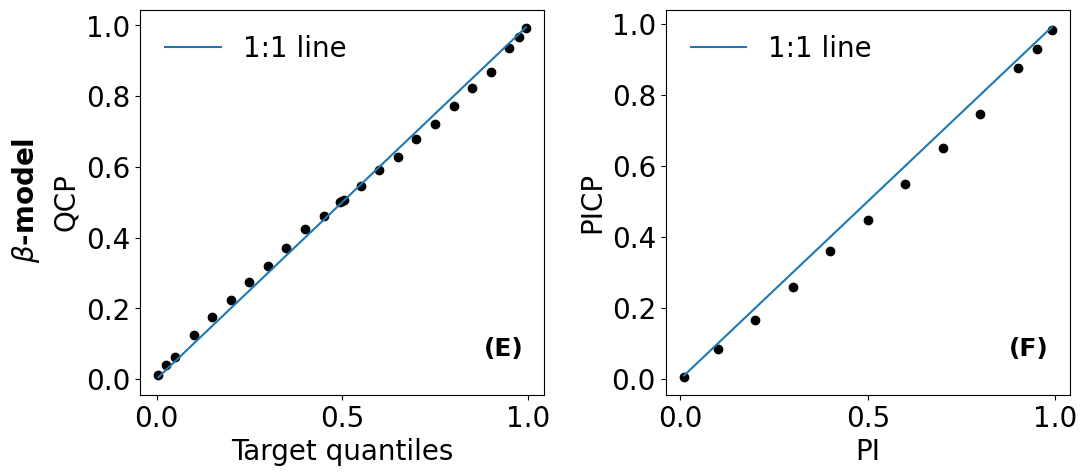

In [30]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot 1: Target quantiles vs. realized quantiles
axs[0].plot(quantiles, quantiles, label='1:1 line')
axs[0].scatter(quantiles, qcp, color='black')
axs[0].set_xlabel('Target quantiles', fontsize=20)
axs[0].set_ylabel('QCP', fontsize=20)
axs[0].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].text(0.85, 0.15, 
         f'(E)', 
         transform=axs[0].transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')

# Plot 2: PI vs. PICP
# ymin, ymax = axs[1].get_ylim()
# axs[1].plot([0.95, 0.95], [0,1], 
#             color='orange', linestyle='--', linewidth=2, label='Target PI 95%:\nPICP 93%')
# axs[1].axvline(x=0.95, color='orange', linestyle='--', linewidth=2)  # Use axvline to draw a vertical line across the entire plot, label=f'Target PI 95%:\nPICP {picp[1]*100:.0f}%'
axs[1].plot(pi, pi, label='1:1 line')
axs[1].scatter(pi, picp, color='black')
axs[1].set_xlabel('PI', fontsize=20)
axs[1].set_ylabel('PICP', fontsize=20)
# axs[1].text(0.26, 0.16, f'PI 95% - PICP 93%', #\n{picp[1]:.2f}
#             ha='left', va='top', transform=axs[1].transAxes, fontsize=20)  # Adjusted text position
axs[1].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].text(0.85, 0.15, 
         f'(F)', 
         transform=axs[1].transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')

# Adjust layout to prevent overlapping and add space between the panels
plt.subplots_adjust(wspace=0.3)  # Increase the space between the two plots
fig.text(0.03, 0.5, r'$\beta$-model', va='center', ha='center', rotation='vertical', fontsize=20, fontweight='bold')
# plt.savefig(f'./figure/plot_mdl.slope_evaluation.{prop}_uncertainty.svg', bbox_inches='tight')

plt.show()

## corresponds to predictions by pnt model

In [31]:
# read in delta modelled by delta model
srs = pd.read_parquet(f'./metric/srs_predicted.pnt_{version}.pq')
srs = srs[['id', 'soc_mean', 'pred_mean', 'pred_series','linear.ts_obsv', 'linear.ts_pred',
           'slope_obsv', 'intercept_obsv', 'score_obsv', 'slope_pred', 'intercept_pred', 'score_pred',
           'direction_pred', 'direction_obsv', 'lc_str', 'slope_std', 'realizations_slope_m', 'score_std', 'realizations_score_m', 'signal', 'noise', 'snr']]

# merge delta predicted by beta model and carbon model
test = test.merge(srs, how='left', on='id')

In [51]:
test.to_parquet(f'./metric/srs_predicted_{version}.pq')

## evaluate prediction accuracy

In [2]:
test = pd.read_parquet(f'./metric/srs_predicted_{version}.pq')

In [6]:
test.columns[-30::]

Index(['cdr_glad.landsat.seasconv_m_30m_s_20000101_20001231_eu_epsg.3035_v20231127_during_std',
       'cdr_glad.landsat.seasconv_m_30m_s_20000101_20001231_eu_epsg.3035_v20231127_during_slope',
       'cdr_glad.landsat.seasconv_m_30m_s_20000101_20001231_eu_epsg.3035_v20231127_full_mean',
       'cdr_glad.landsat.seasconv_m_30m_s_20000101_20001231_eu_epsg.3035_v20231127_full_std',
       'cdr_glad.landsat.seasconv_m_30m_s_20000101_20001231_eu_epsg.3035_v20231127_full_slope',
       'tile_id', 'pred', 'pred_std', 'piw_90', 'soc_mean', 'pred_mean',
       'pred_series', 'linear.ts_obsv', 'linear.ts_pred', 'slope_obsv',
       'intercept_obsv', 'score_obsv', 'slope_pred', 'intercept_pred',
       'score_pred', 'direction_pred', 'direction_obsv', 'lc_str', 'slope_std',
       'realizations_slope_m', 'score_std', 'realizations_score_m', 'signal',
       'noise', 'snr'],
      dtype='object')

/tmp/ipykernel_176763/2097262030.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 1])  # More space at bottom for colorbars


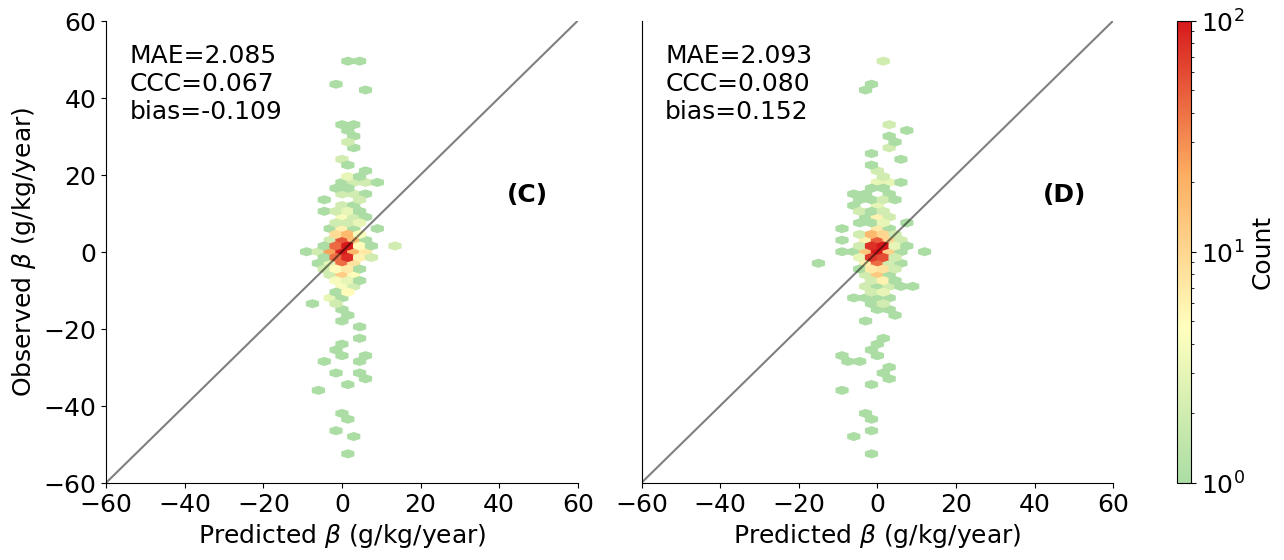

In [19]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from model_fit import calc_metrics
import math
import matplotlib.pyplot as plt

cet_l19_cmap = LinearSegmentedColormap.from_list(
    "CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
)

vmax = 100

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.03], wspace=0.2)

# Subplot 1
show_range = [-60, 60]
ax1 = fig.add_subplot(gs[0])
y_t = test['ts_slope']
y_p = test['pred']
rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_p, y_t, 'normal')
hb1 = ax1.hexbin(y_p, y_t, gridsize=(40, 40), cmap=cet_l19_cmap,
                 extent=[show_range[0], show_range[1], show_range[0], show_range[1]],
                 mincnt=1, vmax=vmax, bins='log')
ax1.set_xlabel(r'Predicted $\beta$ (g/kg/year)')
ax1.set_ylabel(r'Observed $\beta$ (g/kg/year)')
ax1.text(0.05, 0.95, 
         f'MAE={mae:.3f}\nCCC={ccc:.3f}\nbias={bias:.3f}', 
         transform=ax1.transAxes,
         verticalalignment='top',
         fontsize=18)
ax1.text(0.85, 0.65, 
         f'(C)', 
         transform=ax1.transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')
ax1.plot(show_range, show_range, "-k", alpha=0.5)
ax1.set_xlim(show_range)
ax1.set_ylim(show_range)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('', fontsize=20)  # <-- Add this line


# Subplot 2
# show_range = [-5, 5]
ax2 = fig.add_subplot(gs[1])
# y_t = test#test.loc[test['ts_slope'].abs() < 30, 'ts_slope']
y_p = test['slope_pred'] #test.loc[test['ts_slope'].abs() < 30, 'pred']
rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_p, y_t, 'normal')
hb2 = ax2.hexbin(y_p, y_t, gridsize=(40, 40), cmap=cet_l19_cmap,
                 extent=[show_range[0], show_range[1], show_range[0], show_range[1]],
                 mincnt=1, vmax=vmax, bins='log')
ax2.set_xlabel(r'Predicted $\beta$ (g/kg/year)')
ax2.set_ylabel(' ')
ax2.text(0.05, 0.95, 
         f'MAE={mae:.3f}\nCCC={ccc:.3f}\nbias={bias:.3f}', 
         transform=ax2.transAxes,
         verticalalignment='top',
         fontsize=18)
ax2.text(0.85, 0.65, 
         f'(D)', 
         transform=ax2.transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')
ax2.plot(show_range, show_range, "-k", alpha=0.5)
ax2.set_xlim(show_range)
ax2.set_ylim(show_range)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_yticks([])
ax2.set_title('', fontsize=20)  # <-- Add this line

# Colorbar
cbar_ax = fig.add_subplot(gs[2])
cb = fig.colorbar(hb2, cax=cbar_ax)
cb.set_label('Count')
plt.tight_layout(rect=[0, 0.05, 1, 1])  # More space at bottom for colorbars

# fig.text(0.04, 0.5, r'$\beta$-model', va='center', ha='center', rotation='vertical', fontsize=20, fontweight='bold')
plt.savefig(f'./figure/plot_mdl.srs_evaluation.{prop}_pred.svg', bbox_inches='tight')
plt.show()

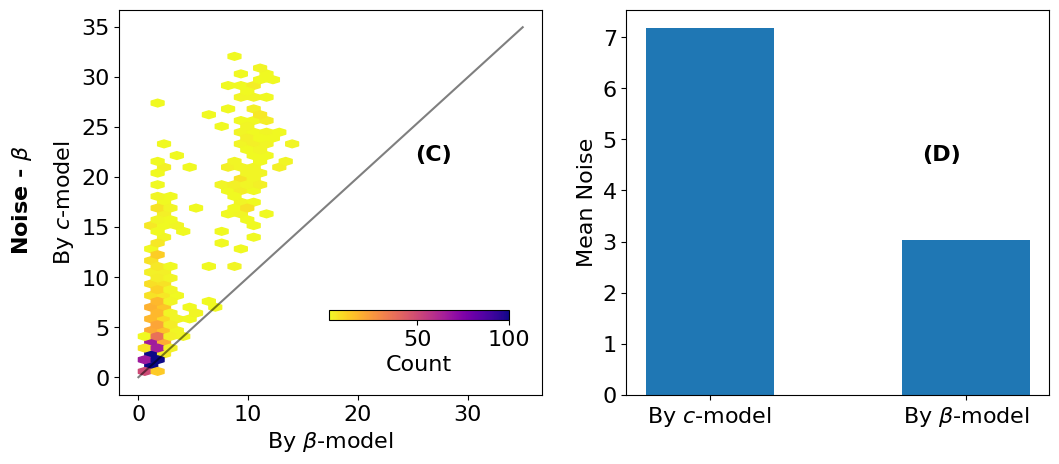

In [46]:
# import matplotlib.pyplot as plt

# plt.rcParams.update({'font.size': 16})

# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # --- Plot 1: Hexbin ---
# ax = axes[0]
# show_range = [0, 35]
# hb = ax.hexbin(
#     test['pred_std'], test['slope_std'],
#     gridsize=(30, 30),
#     extent=[show_range[0], show_range[1], show_range[0], show_range[1]],
#     cmap='plasma_r', mincnt=2, vmax=100
# )
# ax.set_xlabel(r'By $\beta$-model')
# ax.set_ylabel(r'By $c$-model')
# ax.plot(show_range, show_range, "-k", alpha=0.5)
# ax.text(0.73, 0.65, 
#          f'(C)', 
#          transform=ax.transAxes,
#          verticalalignment='top',
#          fontweight='bold')

# # Add colorbar for hexbin
# cbar_ax = fig.add_axes([0.3, 0.26, 0.15, 0.02])  # [left, bottom, width, height]
# cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal')
# cb.set_label('Count')

# # --- Plot 2: Bar plot ---
# ax = axes[1]
# ax.bar(['By $c$-model', r'By $\beta$-model'], [test['slope_std'].mean(), test['pred_std'].mean()], width=0.5)
# ax.set_ylabel('Mean Noise')
# ax.text(0.73, 0.65, 
#          f'(D)', 
#          transform=ax.transAxes,
#          verticalalignment='top',
#          fontweight='bold')

# fig.text(0.044, 0.5,  r'Noise - $\beta$', va='center', ha='center', rotation='vertical', fontweight='bold')
# plt.savefig(f'./figure/plot_mdl.compare_noise.slope.svg', bbox_inches='tight')
# plt.show()